#### Copyright 2020 Connaissance Publishing.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Understanding Deep Learning: Application in Rare Event Prediction**

Author: Chitta Ranjan, Ph.D.

[ProcessMiner, Inc.](https://processminer.com)

cranjan@processminer.com

LinkedIn: https://www.linkedin.com/in/chitta-ranjan-b0851911/

Medium: https://medium.com/@cran2367

# Long short term memory (LSTM) Network for Rare Event Prediction

# Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/understanding-deep-learning/codebase'
import os
os.chdir(root_path)

Mounted at /content/gdrive


In [ ]:
os.getcwd()

# Libraries

In [ ]:
get_ipython().magic('matplotlib inline')

%tensorflow_version 2.x
import tensorflow as tf

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional

from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# user-defined libraries
import utilities.datapreprocessing as dp
import utilities.performancemetrics as pm
import utilities.simpleplots as sp

from numpy.random import seed
seed(1)

SEED = 123  # used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.rcParams.update({'font.size': 22})

# Data Preparation

## Read and process data

The data is taken from https://arxiv.org/abs/1809.10717. Please use this source for any citation.

In [ ]:
'''Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdPCkTFW1wTp6tAP1C1BhT7HWTQ60-GfCGvWs9Ca4WbR0FIdg/viewform
'''
df = pd.read_csv("data/processminer-sheet-break-rare-event-dataset.csv")
df.head(n=5)  # visualize the data.

,DateTime,SheetBreak,RSashScanAvg,CT#1 BLADE PSI,P4 CT#2 BLADE PSI,Bleached GWD Flow,ShwerTemp,BlndStckFloTPD,C1 BW SPREAD CD,RS BW SPREAD CD,C1 BW SPREAD MD,RS BW SPREAD MD,C1 BW SCAN AVG,RS BW SCAN AVG,CoatBrkFlo,Clay Flow,CouchLoVac,COUCH VAC,4PrsTopLd,4PrsBotLod,CalndrDrw,2DryrDrw,3DryrDrw,4DryrDraw,1PrsTopDrw,4PrsBotDrw,FanPmpSpd,FlBxHdrVac,FlatBxVac,Grade&Bwt,UnblGWDFlo,Hdbox pH,HdBxLiqLvl,"TotHead""",HorzSlcPos,KraftFlow,CouchLoad,C1MoSprdCD,RSMoSprdCD,C1MoSprdMD,RSMoSprdMD,RL MoisAct,PrScrRjFlo,RwBrkFlo,RcycFbrFlo,RetnAidFlo,RUSH DRAG,Rush/Drag,SilicaFlo,HBxSlcTemp,SodAlumFlo,CouchSpd,MachSpd,1PrsTopSpd,4PrsBotSpd,WtNStarFlo,BasWgtFlo,TMP Flow,HBxTotHead,TrayCons,UpprHdTmpRL,VertSlcPos,EventPress
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,0.877951,-0.052959,-13.306135,0.101068,0.041800,0.199901,-2.327329,-0.944167,3.075199,0.123154,-0.104334,-0.570710,-9.784456,0.355960,15.842819,-0.451974,-0.105282,96,-134.277862,0.058726,-0.021645,9.366755,0.002151,-69.187583,4.232571,-0.225267,-0.196872,-0.072449,-0.103732,-0.720746,-5.412436,76.679042,-0.632727,1351.632859,-0.657095,-0.434947,-108.775969,0.084856,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230658,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,0.873273,-0.014244,-13.306135,0.101108,0.041447,0.304313,-2.340627,-0.939994,3.075199,0.123154,-0.104334,-0.574861,-9.784456,0.360160,16.491684,-0.450451,-0.092430,96,-134.480194,0.058759,-0.004579,9.350215,0.002149,-68.585197,4.311490,-0.225267,-0.196872,-0.059103,-0.083895,-0.720746,-8.343222,78.181598,-0.632727,1370.378949,-0.875628,-1.125819,-108.848967,0.085146,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,1.004910,0.065150,-9.619596,0.101148,0.041095,0.252839,-2.353925,-0.935824,3.075199,0.123154,-0.104334,-0.579013,-9.784456,0.364356,15.972885,-0.448927,-0.097144,96,-133.946587,0.058791,-0.084658,9.037409,0.002148,-67.838187,4.809914,-0.225267,-0.186801,-0.048696,-0.073823,-0.720746,-1.085166,79.684154,-0.632727,1368.123089,-0.037775,-0.519541,-109.086577,0.085436,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,0.930037,-0.067199,-15.196531,0.101188,0.040742,0.072873,-2.367223,-0.931651,3.075199,0.123154,-0.104334,-0.583165,-9.784456,0.368556,15.608688,-0.447404,-0.160073,96,-134.002586,0.058824,-0.055118,9.020625,0.002146,-67.091148,5.308343,-0.225267,-0.186801,-0.047017,-0.063752,-0.720746,6.172891,81.186702,-0.632727,1365.691449,-0.987410,0.674524,-109.562774,0.085726,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,0.828410,-0.018472,-14.609266,0.101229,0.040390,0.171033,-2.380521,-0.927478,3.075199,0.123154,-0.104334,-0.587316,-9.784456,0.372756,15.606125,-0.445880,-0.131630,96,-133.145706,0.058856,-0.153851,9.344233,0.002145,-65.991813,5.806771,-0.225267,-0.186801,-0.057088,-0.063752,-0.720746,-3.379599,82.689258,-0.632727,1363.257859,-0.238444,-0.063044,-110.038909,0.086016,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [ ]:
# Convert Categorical column to hot dummy columns
hotencoding1 = pd.get_dummies(df['Grade&Bwt'])
hotencoding1 = hotencoding1.add_prefix('grade_')
hotencoding2 = pd.get_dummies(df['EventPress'])
hotencoding2 = hotencoding2.add_prefix('eventpress_')

df=df.drop(['Grade&Bwt', 'EventPress'], axis=1)

df=pd.concat([df, hotencoding1, hotencoding2], axis=1)

# Rename response column name for ease of understanding
df=df.rename(columns={'SheetBreak':'y'})

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = dp.curve_shift(df, shift_by=-2)

# Sort by time and drop the time column.
df['DateTime'] = pd.to_datetime(df.DateTime)
df = df.sort_values(by='DateTime')
df = df.drop(['DateTime'], axis=1)

## Data temporalization

LSTM is a bit more demanding than other models. Significant amount of time and attention goes in preparing the data that fits an LSTM.

First, we will create the 3-dimensional arrays of shape: (samples x timesteps x features). Samples mean the number of data points. Timesteps is the number of time steps we look back at any time t to make a prediction. This is also referred to as lookback period. The features is the number of features the data has, in other words, the number of predictors in a multivariate data.

In [ ]:
input_X = df.loc[:, df.columns != 'y'].values  # converts df to numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features

In LSTM, to make prediction at any time t, we will look at data from (t-lookback):t. In the following, we have an example to show how the input data are transformed with the `temporalize` function with a `lookback`. For the modeling, we may use a longer lookback.

In [ ]:
# Temporalize the data
lookback = 5
X, y = dp.temporalize(X=input_X, 
                      y=input_y, 
                      lookback=lookback)

The two tables are the same. This testifies that we are correctly taking 3 samples (= lookback), X(t):X(t-3) to predict y(t).

## Divide the data into train, valid, and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X),
    np.array(y),
    test_size=DATA_SPLIT_PCT,
    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=DATA_SPLIT_PCT,
    random_state=SEED)

In [ ]:
X_train.shape

TIMESTEPS = X_train.shape[1]  # equal to the lookback
N_FEATURES = X_train.shape[2]  # the number of features


## Scaling the data
It is usually better to use a scaled data.

One common mistake is: we scale the entire data and then split into train-test. This is not correct. Test data should be completely unseen to anything during the modeling. We should scale the test data using the feature summary statistics computed from the training data. For standardization, these statistics are the mean and variance for each feature. 

The same logic should be used for the validation set. This makes the model more stable for a test data.

To do this on the temporalized data, we will require two UDFs.

- `flatten`: This function will re-create the original 2D array from which the 3D temporalized arrays we created. This function is the inverse of `temporalize`, meaning `X = flatten(temporalize(X))`.
- `scale`: This function will scale a 3D temporalized array that we created as inputs to the LSTM.

In [ ]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(dp.flatten(X_train))
X_train_scaled = dp.scale(X_train, scaler)

In [ ]:
X_valid_scaled = dp.scale(X_valid, scaler)
X_test_scaled = dp.scale(X_test, scaler)

# LSTM Classifier

### Model 1a. Baseline---A Restricted Stateless LSTM Network.

The last LSTM layer is stateless and has restricted output, i.e., outputs only the last hidden output.

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES), 
                name='input'))
model.add(
    LSTM(units=16, 
         activation='tanh',
         recurrent_activation='sigmoid',
         return_sequences=True, 
         name='lstm_layer_1'))
model.add(
    LSTM(units=8, 
         activation='tanh', 
         recurrent_activation='sigmoid',
         return_sequences=False, 
         name='lstm_layer_2'))
model.add(Dense(units=1, 
                activation='sigmoid', 
                name='output'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 8)                 800       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 6,313
Trainable params: 6,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Number of parameters = 4l(p + l + 1), 
# l = layer size, p = number of features.
4*16*(n_features + 16 + 1)

5504

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])

In [ ]:
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, 
                                     y_valid),
                    verbose=0).history

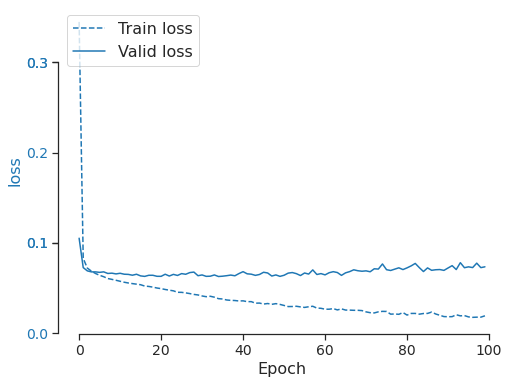

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_loss.pdf', bbox_inches='tight')

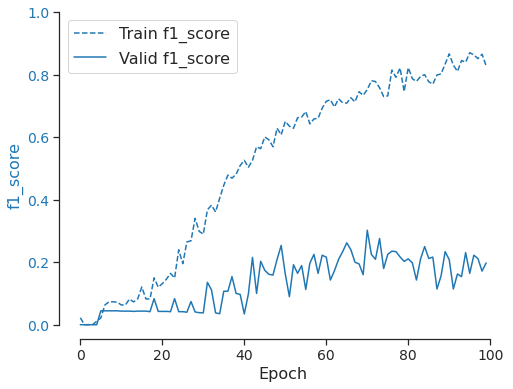

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_f1_score.pdf', bbox_inches='tight')

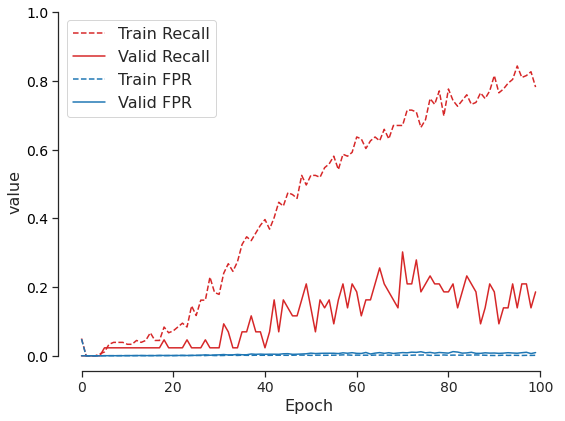

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_recall_fpr.pdf', bbox_inches='tight')

## Model 1b. Baseline---A Restricted Stateless LSTM Network with ReLU activation.

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES), 
                name='input'))
model.add(
    LSTM(units=16, 
         activation='relu',
         recurrent_activation='sigmoid',
         return_sequences=True, 
         name='lstm_layer_1'))
model.add(
    LSTM(units=8, 
         activation='relu', 
         recurrent_activation='sigmoid',
         return_sequences=False, 
         name='lstm_layer_2'))
model.add(Dense(units=1, 
                activation='sigmoid', 
                name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 8)                 800       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 6,313
Trainable params: 6,313
Non-trainable params: 0
_________________________________________________________________


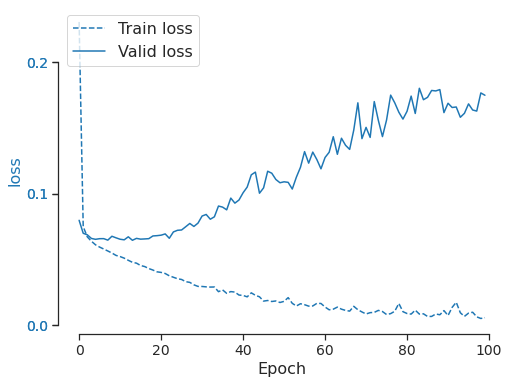

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('lstm_baseline_relu_loss.pdf', bbox_inches='tight')

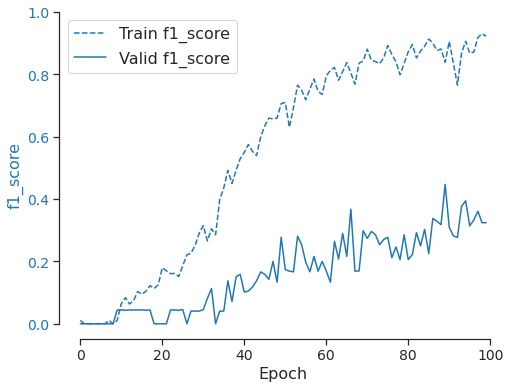

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_baseline_relu_f1_score.pdf', bbox_inches='tight')

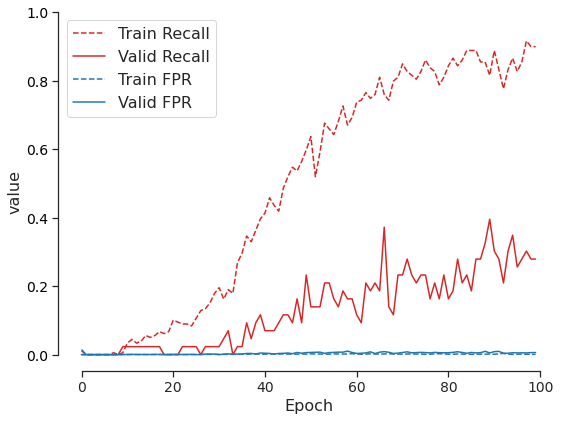

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('lstm_baseline_relu_recall_fpr.pdf', bbox_inches='tight')

## Model 2. Unrestricted LSTM

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES),
                name='input'))
model.add(
    LSTM(units=16,
         activation='relu',
         recurrent_activation='sigmoid',
         return_sequences=True,
         name='lstm_layer_1'))
model.add(
    LSTM(units=8,
         activation='relu',
         recurrent_activation='sigmoid',
         return_sequences=True, 
         name='lstm_layer_2'))
model.add(Flatten())
model.add(Dense(units=1,
                activation='sigmoid', 
                name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled,
                                     y_valid),
                    verbose=0).history

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 5, 8)              800       
_________________________________________________________________
flatten_2 (Flatten)          (None, 40)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 6,345
Trainable params: 6,345
Non-trainable params: 0
_________________________________________________________________


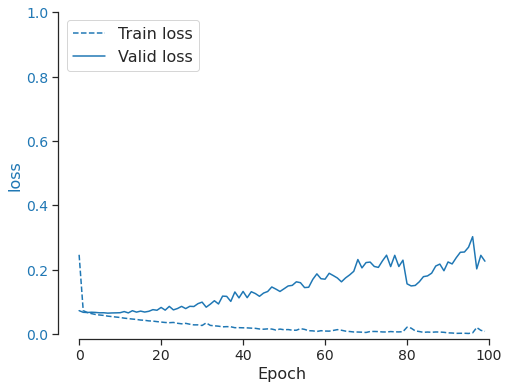

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss', ylim=[0., 1.])
fig.savefig('lstm_unrestricted_flatten_loss.pdf', bbox_inches='tight')

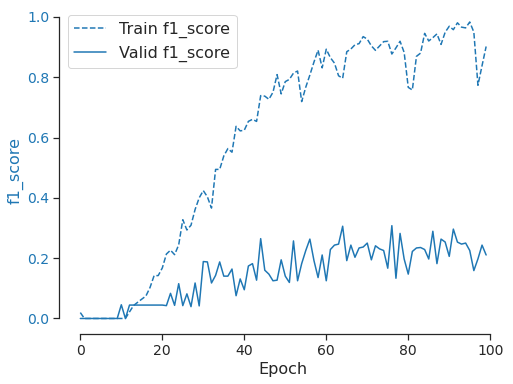

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_unrestricted_flatten_f1_score.pdf', bbox_inches='tight')

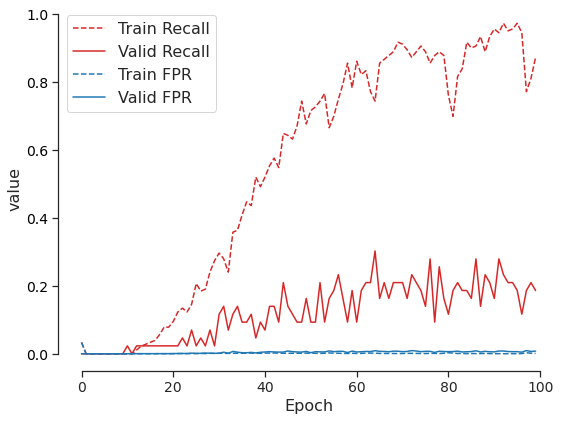

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('lstm_unrestricted_flatten_recall_fpr.pdf', bbox_inches='tight')

## Model 3. Recurrent Dropout

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES), 
                name='input'))
model.add(
    LSTM(units=16,
         activation='relu',
         return_sequences=True,
         recurrent_dropout=0.5,
         name='lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    LSTM(units=8,
         activation='relu',
         return_sequences=True,
         recurrent_dropout=0.5,
         name='lstm_layer_2'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=1,
                activation='sigmoid', 
                name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=200,
                    validation_data=(X_valid_scaled, 
                                     y_valid),
                    verbose=0).history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 16)             0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 5, 8)              800       
_________________________________________________________________
flatten_1 (Flatten)          (None, 40)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 6,345
Trainable params: 6,345
Non-trainable params: 0
____________________________________________________

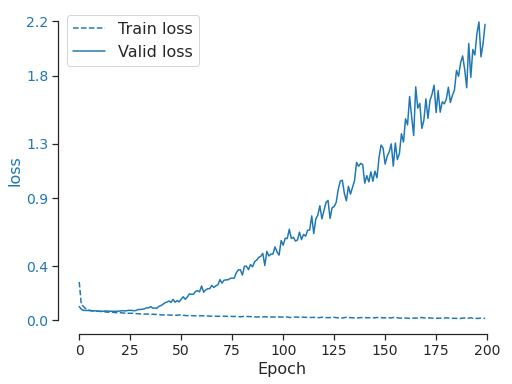

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('lstm_rec_dropout_flatten_loss.pdf', bbox_inches='tight')

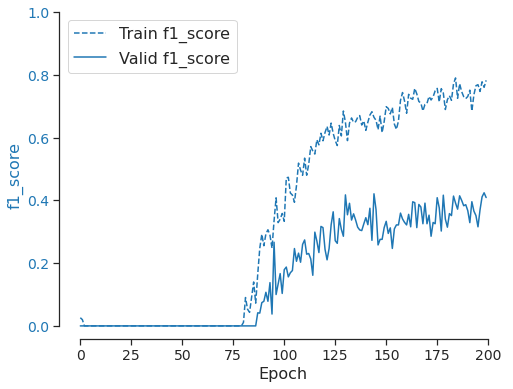

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.], grid=False)
fig.savefig('lstm_rec_dropout_flatten_f1_score.pdf', bbox_inches='tight')

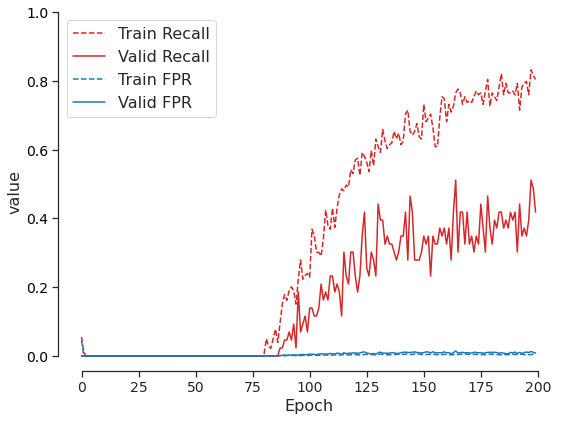

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('lstm_rec_dropout_flatten_recall_fpr.pdf', bbox_inches='tight')

## Model 4. Go Backwards

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES),
                name='input'))
model.add(
    LSTM(units=16,
         activation='relu',
         return_sequences=True,
         go_backwards=True,
         name='lstm_layer_1'))
model.add(
    LSTM(units=8,
         activation='relu',
         return_sequences=True,
         name='lstm_layer_2'))
model.add(Flatten())
model.add(Dense(units=1,
                activation='sigmoid', 
                name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled,
                                     y_valid),
                    verbose=0).history

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 5, 16)             5504      
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 5, 8)              800       
_________________________________________________________________
flatten_9 (Flatten)          (None, 40)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 41        
Total params: 6,345
Trainable params: 6,345
Non-trainable params: 0
_________________________________________________________________


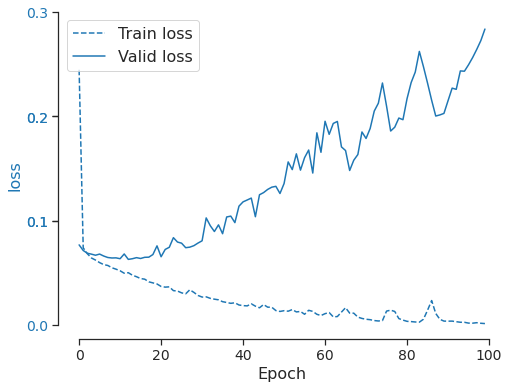

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('lstm_unrestricted_go_backwards_loss.pdf', bbox_inches='tight')

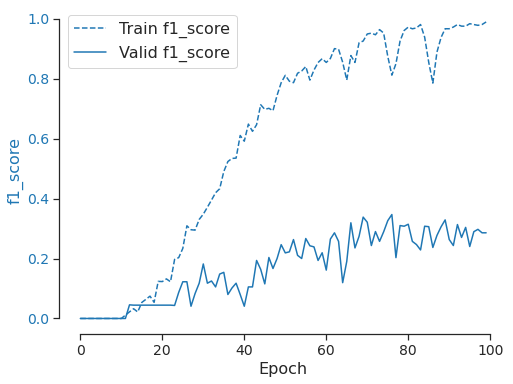

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_unrestricted_go_backwards_f1_score.pdf', bbox_inches='tight')

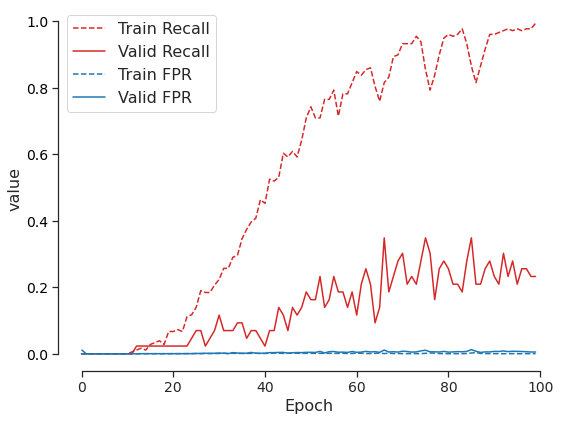

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('lstm_unrestricted_go_backwards_recall_fpr.pdf', bbox_inches='tight')

## Model 5. Bidirectional LSTM

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES),
                name='input'))
model.add(
    Bidirectional(
        LSTM(units=16, 
             activation='relu',
             return_sequences=True), 
        name='bi_lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    Bidirectional(
        LSTM(units=8,
             activation='relu', 
             return_sequences=True),
        name='bi_lstm_layer_2'))
model.add(Flatten())
model.add(Dense(units=1,
                activation='sigmoid', 
                name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])

history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, 
                                     y_valid),
                    verbose=0).history

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bi_lstm_layer_1 (Bidirection (None, 5, 32)             11008     
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
bi_lstm_layer_2 (Bidirection (None, 5, 16)             2624      
_________________________________________________________________
flatten_12 (Flatten)         (None, 80)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 81        
Total params: 13,713
Trainable params: 13,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Number of parameters in bi-directional lstm
4 * 8 * (32 + 8 + 1) * 2

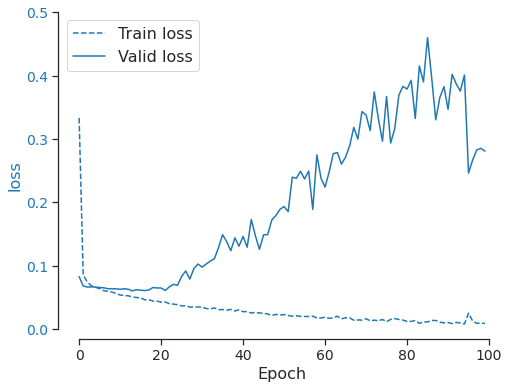

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('lstm_unrestricted_bidirectional_loss.pdf', bbox_inches='tight')

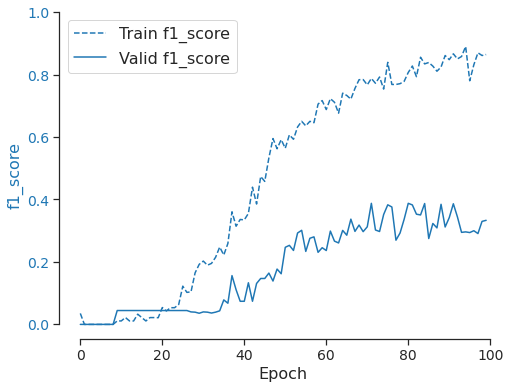

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.], grid=False)
fig.savefig('lstm_unrestricted_bidirectional_f1_score.pdf', bbox_inches='tight')

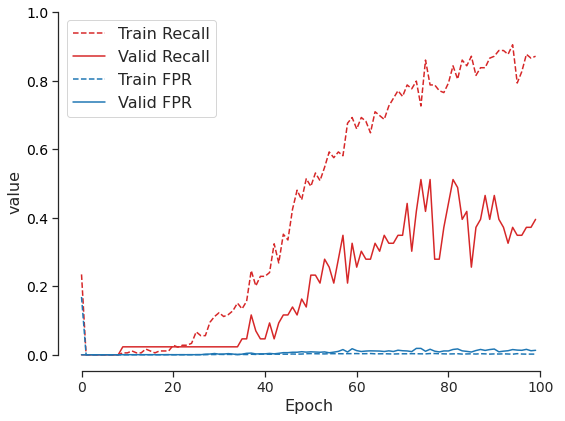

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('lstm_unrestricted_bidirectional_recall_fpr.pdf', bbox_inches='tight')

## Model 6. Longer lookback

### Data preparation

In [ ]:
lookback = 20  # Equivalent to 40 min of past data.
# Temporalize the data
X, y = dp.temporalize(X=input_X, 
                   y=input_y,
                   lookback=lookback)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train = X_train.reshape(X_train.shape[0], 
                          lookback, 
                          n_features)
X_valid = X_valid.reshape(X_valid.shape[0],
                          lookback,
                          n_features)
X_test = X_test.reshape(X_test.shape[0],
                        lookback,
                        n_features)

# Initialize a scaler using the training data.
scaler = StandardScaler().fit(dp.flatten(X_train))

X_train_scaled = dp.scale(X_train, scaler)
X_valid_scaled = dp.scale(X_valid, scaler)
X_test_scaled = dp.scale(X_test, scaler)

### Model fitting

In [ ]:
timesteps = X_train_scaled.shape[1]

model = Sequential()
model.add(Input(shape=(timesteps, N_FEATURES), 
                name='input'))
model.add(
    LSTM(units=16,
         activation='relu',
         return_sequences=True,
         recurrent_dropout=0.5,
         name='lstm_layer_1'))
model.add(Dropout(0.5))
model.add(
    LSTM(units=8,
         activation='relu',
         return_sequences=True,
         recurrent_dropout=0.5,
         name='lstm_layer_2'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=1,
                activation='sigmoid', 
                name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=200,
                    validation_data=(X_valid_scaled, 
                                     y_valid),
                    verbose=0).history

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 20, 16)            5504      
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 20, 8)             800       
_________________________________________________________________
flatten_16 (Flatten)         (None, 160)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 160)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 161       
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
___________________________________________________

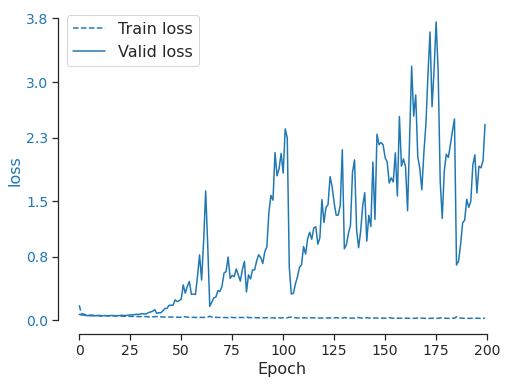

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('lstm_dropout_flatten_long_lookback_loss.pdf', bbox_inches='tight')

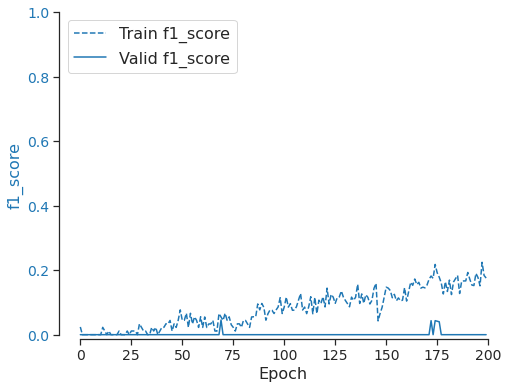

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_dropout_flatten_long_lookback_f1_score.pdf', bbox_inches='tight')

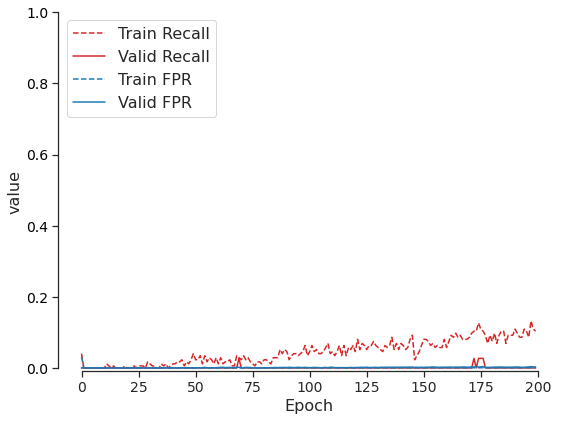

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('lstm_dropout_flatten_long_lookback_recall_fpr.pdf', bbox_inches='tight')

# Stateful LSTM

## Data preparation for stateful LSTM

In [ ]:
# Time ordered original data.
lookback_stateful = 1
# Temporalize the data
X, y = temporalize(X=input_X, y=input_y, lookback=lookback_stateful)

batch_size = 128

# Train, valid and test size set to match the previous models.
train_size = 13002
valid_size = 3251
test_size = 3251

X_train_stateful, y_train_stateful = np.array(
    X[0:int(train_size / batch_size) * batch_size]), np.array(
        y[0:int(train_size / batch_size) * batch_size])
X_valid_stateful, y_valid_stateful = np.array(
    X[int(train_size / batch_size) *
      batch_size:int((train_size + valid_size) / batch_size) *
      batch_size]), np.array(
          y[int(train_size / batch_size) *
            batch_size:int((train_size + valid_size) / batch_size) *
            batch_size])
X_test_stateful, y_test_stateful = np.array(
    X[int((train_size + test_size) / batch_size) * batch_size:]), np.array(
        y[int((train_size + test_size) / batch_size) * batch_size:])

X_train_stateful = X_train_stateful.reshape(X_train_stateful.shape[0],
                                            lookback_stateful, n_features)
X_valid_stateful = X_valid_stateful.reshape(X_valid_stateful.shape[0],
                                            lookback_stateful, n_features)
X_test_stateful = X_test_stateful.reshape(X_test_stateful.shape[0],
                                          lookback_stateful, n_features)

scaler_stateful = StandardScaler().fit(flatten(X_train_stateful))

X_train_stateful_scaled = scale(X_train_stateful, scaler_stateful)

X_valid_stateful_scaled = scale(X_valid_stateful, scaler_stateful)
X_test_stateful_scaled = scale(X_test_stateful, scaler_stateful)

## Model construction

In [ ]:
timesteps_stateful = X_train_stateful_scaled.shape[1]
n_features_stateful = X_train_stateful_scaled.shape[2]

model = Sequential()
model.add(
    Input(shape=(timesteps_stateful, n_features_stateful),
          batch_size=batch_size,
          name='input'))
model.add(
    LSTM(8,
         activation='relu',
         return_sequences=True,
         stateful=True,
         name='lstm_layer_1'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  performancemetrics.F1Score(),
                  performancemetrics.FalsePositiveRate()
              ])

class ResetStatesCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()

history = model.fit(x=X_train_stateful_scaled,
                    y=y_train_stateful,
                    callbacks=[ResetStatesCallback()],
                    batch_size=batch_size,
                    epochs=100,
                    shuffle=False,
                    validation_data=(X_valid_stateful_scaled,
                                     y_valid_stateful),
                    verbose=1).history

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (128, 1, 8)               2496      
_________________________________________________________________
flatten_13 (Flatten)         (128, 8)                  0         
_________________________________________________________________
output (Dense)               (128, 1)                  9         
Total params: 2,505
Trainable params: 2,505
Non-trainable params: 0
_________________________________________________________________
Train on 12928 samples, validate on 3200 samples
Epoch 1/100
12928/12928 [==============================] - 1s 62us/sample - loss: 0.3101 - accuracy: 0.7712 - recall_23: 0.3653 - f1_score: 0.0396 - false_positive_rate: 0.2235 - val_loss: 0.2016 - val_accuracy: 0.9572 - val_recall_23: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0258
Epoch 2/100
12928/12928 

12928/12928 [==============================] - 0s 17us/sample - loss: 0.0638 - accuracy: 0.9872 - recall_23: 0.0240 - f1_score: 0.0462 - false_positive_rate: 1.5673e-04 - val_loss: 0.1466 - val_accuracy: 0.9816 - val_recall_23: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 9.5420e-04
Epoch 51/100
12928/12928 [==============================] - 0s 17us/sample - loss: 0.0637 - accuracy: 0.9872 - recall_23: 0.0240 - f1_score: 0.0462 - false_positive_rate: 1.5673e-04 - val_loss: 0.1472 - val_accuracy: 0.9816 - val_recall_23: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 9.5420e-04
Epoch 52/100
12928/12928 [==============================] - 0s 18us/sample - loss: 0.0637 - accuracy: 0.9872 - recall_23: 0.0240 - f1_score: 0.0462 - false_positive_rate: 1.5673e-04 - val_loss: 0.1455 - val_accuracy: 0.9812 - val_recall_23: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0013
Epoch 53/100
12928/12928 [==============================] - 0s 16u

Epoch 76/100
12928/12928 [==============================] - 0s 17us/sample - loss: 0.0616 - accuracy: 0.9872 - recall_23: 0.0240 - f1_score: 0.0462 - false_positive_rate: 1.5673e-04 - val_loss: 0.1426 - val_accuracy: 0.9825 - val_recall_23: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 77/100
12928/12928 [==============================] - 0s 16us/sample - loss: 0.0618 - accuracy: 0.9872 - recall_23: 0.0240 - f1_score: 0.0462 - false_positive_rate: 1.5673e-04 - val_loss: 0.1357 - val_accuracy: 0.9825 - val_recall_23: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 78/100
12928/12928 [==============================] - 0s 17us/sample - loss: 0.0616 - accuracy: 0.9872 - recall_23: 0.0240 - f1_score: 0.0462 - false_positive_rate: 1.5673e-04 - val_loss: 0.1309 - val_accuracy: 0.9825 - val_recall_23: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 79/100
12928/12928 [=======================

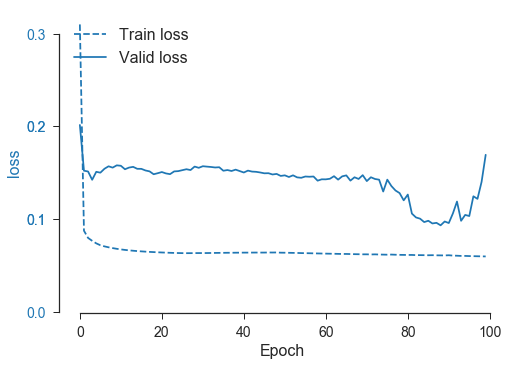

In [ ]:
plt, fig = simpleplots.plot_metric(history, metric='loss')
fig.savefig('lstm_full_stateful_loss.pdf', bbox_inches='tight')

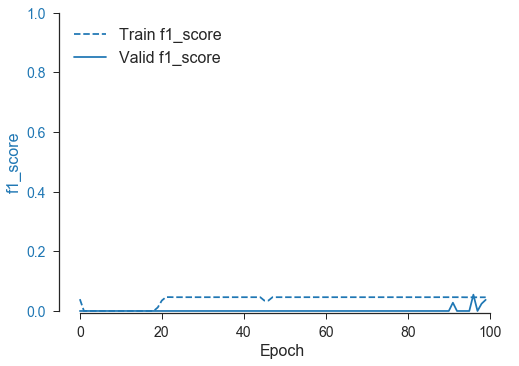

In [ ]:
plt, fig = simpleplots.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('lstm_full_stateful_f1_score.pdf', bbox_inches='tight')

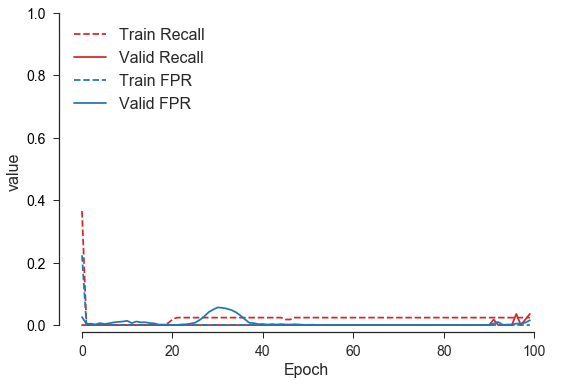

In [ ]:
plt, fig = simpleplots.plot_model_recall_fpr(history)
fig.savefig('lstm_full_stateful_recall_fpr.pdf', bbox_inches='tight')

# `tanh` activation

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES), 
                name='input'))
model.add(
    Bidirectional(
        LSTM(units=16, 
             activation='tanh', 
             return_sequences=True,
             name='lstm_layer_1')))
model.add(Dropout(0.5))
model.add(
    Bidirectional(
        LSTM(units=8, 
             activation='tanh', 
             return_sequences=True,
             name='lstm_layer_2')))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=1,
                activation='sigmoid', 
                name='output'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 32)             11008     
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5, 16)             2624      
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 81        
Total params: 13,713
Trainable params: 13,713
Non-trainable params: 0
____________________________________________________

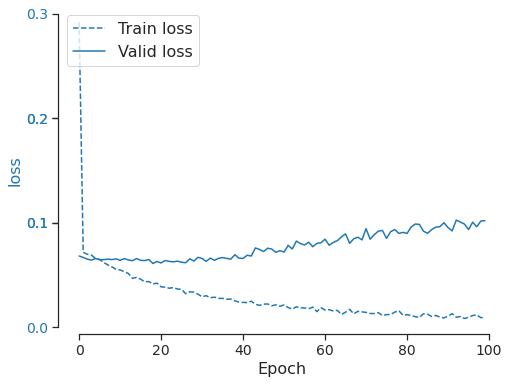

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')

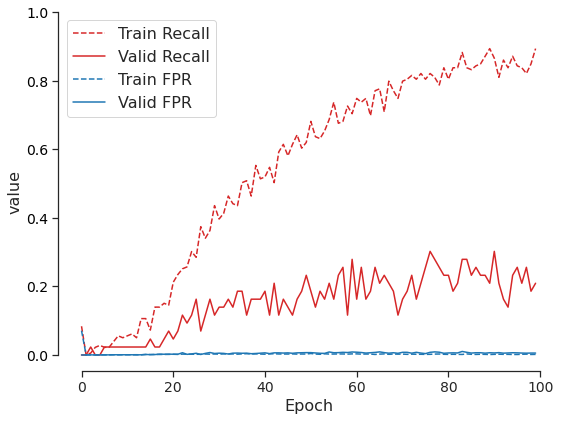

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)